# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [3]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
import pickle
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [30, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [4]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')


## Time series analysis in Python
Analyse aus: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook 25.07.24, 10:56
Und aus Atwan.2022: *Time Series Analysis*. 10 Building Univariate Time Series Models Using Statistical Methods: https://learning.oreilly.com/library/view/time-series-analysis/9781805124283/text/ch011.xhtml#join-our-book-community-on-discord-9

### Hilfsfunkktionen: check_stationarity, get_top_models_df, plot_forecast, combinator

In [5]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

## Vorbereitungen des Daten df_hourly für SARIMAX
### ACF und PACF für df_hourly

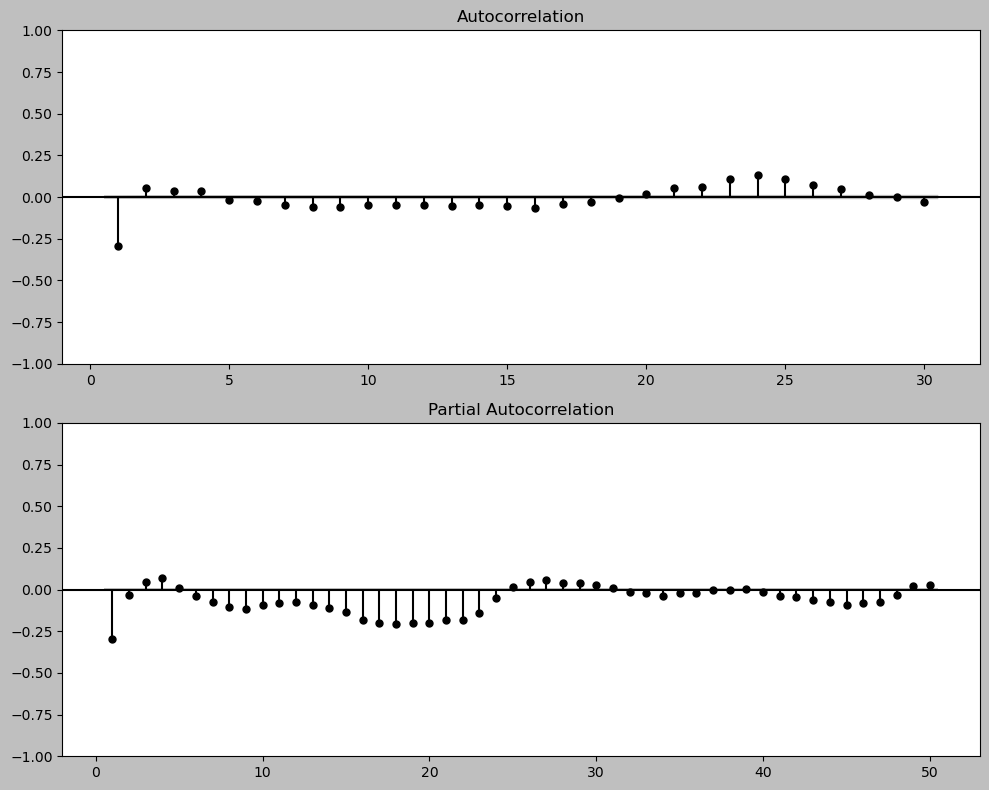

In [5]:
# ACF und PACF
# Nur die Spalte 'calls' auswählen und Differenz berechnen
hourly_diff = df_hourly['calls'].diff().dropna()

# ACF und PACF Plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(hourly_diff, zero=False, lags=30, ax=ax[0])
plot_pacf(hourly_diff, zero=False, lags=50, ax=ax[1])
plt.tight_layout()
plt.show()


Analyse der Plots (von ChatGPT):
1. Autokorrelation (ACF-Plot):

    Es gibt signifikante Autokorrelationen (Punkte außerhalb des grauen Bereichs) in den ersten wenigen Lags.
    Ab Lag 1 sinken die Korrelationen und nähern sich langsam Null an. Das deutet darauf hin, dass kurzfristige Abhängigkeiten bestehen, aber keine langfristigen Trends vorliegen.
    Bei Lags, die Vielfache von 24 sind (z. B. Lag 24), könnten saisonale Muster sichtbar werden (d. h., tägliche Wiederholungen).

2. Partielle Autokorrelation (PACF-Plot):

    Die PACF zeigt in den ersten Lags einige signifikante Werte, danach nähern sich die Werte ebenfalls Null.
    Dies deutet darauf hin, dass ein AR-Term (autoregressiver Term) mit niedrigem Grad sinnvoll sein könnte.

3. Fehlen eines grauen Bereichs:

    Der graue Bereich repräsentiert das 95%-Konfidenzintervall, innerhalb dessen die Werte zufällige Schwankungen darstellen könnten.
    Dass fast kein grauer Bereich sichtbar ist, bedeutet:
        Große Datenmenge: Mit sehr vielen Datenpunkten wird der Standardfehler kleiner, was zu schmaleren Konfidenzintervallen führt.
        Die meisten Punkte, die außerhalb des Bereichs liegen, sind tatsächlich signifikant.  
  
**Fehlen des grauen Bereichs**  
Was es bedeutet:

Sehr starke Autokorrelation:
    Deine Daten zeigen ein starkes Abhängigkeitsmuster, das entweder von einer saisonalen Komponente, einem Trend oder anderen systematischen Faktoren herrührt.
    Das ist nicht unbedingt "schlecht", zeigt aber, dass die Daten vor der Modellierung möglicherweise weitere Transformationen oder Differenzierungen benötigen.

Extrem schmale Konfidenzintervalle:
    Wenn die Datenmenge sehr groß ist, werden die Konfidenzintervalle schmaler. Das führt dazu, dass selbst kleine Abweichungen signifikant werden. Dies könnte technisch "überbewertet" sein und dir suggerieren, dass es mehr Signifikanz gibt als tatsächlich notwendig.

Fehler in der Datenvorbereitung:
    Falls die Daten nicht korrekt skaliert, transformiert oder differenziert wurden, könnten die Plots nicht die tatsächliche Struktur der Daten widerspiegeln.

In [6]:
# Make Time Series Stationary

# Anwendung auf df_hourly
hourly_diff_24 = df_hourly['calls'].diff(24).dropna()
check_stationarity(hourly_diff_24)

'Stationary	 p-value:0.0 	 lags:51


('Stationary', 0.0)

Interpretation von ChatGPT:  
  
1. Stationarity

    Stationary: Die Zeitreihe wird durch den Augmented Dickey-Fuller-Test (ADF) als stationär erkannt. Das bedeutet:
        Es gibt keine systematischen Trends (z. B. Aufwärtstrend oder Abwärtstrend).
        Die Varianz bleibt konstant.
        Es gibt keine stark ausgeprägten saisonalen Muster mehr.

2. p-value

    p-value: 0.0:
        Der p-Wert ist extrem klein (im Wesentlichen Null), was die Nullhypothese des ADF-Tests (dass die Zeitreihe nicht stationär ist) mit sehr hoher Sicherheit ablehnt.
        Dies ist ein sehr starkes Indiz dafür, dass die Zeitreihe jetzt stationär ist.

3. Lags

    lags: 51:
        Das bedeutet, dass im ADF-Test bis zu 51 vergangene Zeitpunkte (Lags) berücksichtigt wurden, um die Autokorrelation der Zeitreihe zu testen.
        Dies ist normal für Zeitreihen mit saisonalen Mustern, da die Autokorrelation vor der Differenzierung sehr stark war (z. B. Wiederholungen in 24-Stunden-Zyklen).

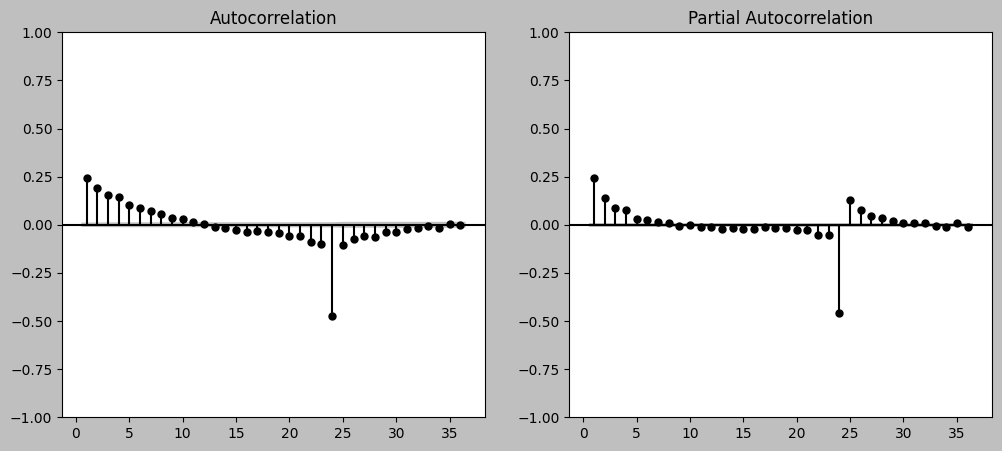

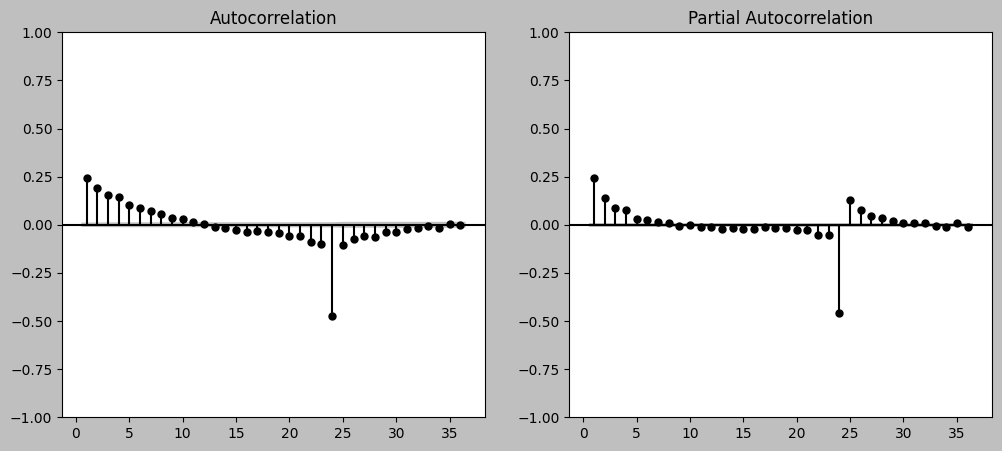

In [15]:
fig, ax = plt.subplots(1,2)
plot_acf(hourly_diff_24, zero=False, ax=ax[0], lags=36)
plot_pacf(hourly_diff_24, zero=False, ax=ax[1], lags=36)

Analyse der Plots (neu interpretiert):
1. ACF (Autokorrelation):

    Fast linear absteigend von Lag 0 bis Lag 23:
    Dieses Verhalten ist typisch für einen nicht-stationären Prozess, was eine Differenzierung (d=1d=1) erforderlich macht.

    Starker negativer Peak bei Lag 24 (-0,5):
    Dies deutet auf eine saisonale Komponente mit Periodizität von 24 hin. Da es ein negativer Peak ist, spricht dies für eine saisonale Moving-Average-Komponente (SMA(Q)SMA(Q)).

    Nach Lag 24: Stückweise Annäherung an 0:
    Das bedeutet, dass nach der Berücksichtigung der Saisonalität keine starke weitere Struktur übrig bleibt.

2. PACF (Partielle Autokorrelation):

    Fast linear absteigend von Lag 0 bis Lag 23:
    Auch hier zeigt sich eine Notwendigkeit zur Differenzierung (d=1d=1).

    Starker negativer Peak bei Lag 24 (-0,5):
    Dies unterstützt die Annahme einer saisonalen Autokorrelationsstruktur (SAR(P)SAR(P)) oder einer saisonalen Moving-Average-Komponente (SMA(Q)SMA(Q)).

    Nach Lag 24: Stückweise Annäherung an 0:
    Auch hier keine weiteren signifikanteren Strukturen.

Modellvorschlag:

Das Muster weist auf eine klare Saisonalität mit einer Periode von 24 (z. B. stündliche Daten mit einem täglichen Muster) hin. Daraus ergibt sich ein SARIMA-Modell:
SARIMA(p,d,q)×(P,D,Q,s)
SARIMA(p,d,q)×(P,D,Q,s)

    Nicht-saisonale Komponenten:
        p=1p=1: Ein autoregressiver Term, da der PACF an Lag 1 positiv startet.
        d=1d=1: Differenzierung wegen der nicht-stationären Struktur.
        q=0q=0: Kein Hinweis auf eine nicht-saisonale Moving-Average-Komponente.

    Saisonale Komponenten:
        P=0P=0: Kein saisonaler autoregressiver Term (keine saisonalen Peaks im PACF).
        D=1D=1: Eine saisonale Differenzierung wegen des saisonalen Peaks.
        Q=1Q=1: Eine Moving-Average-Komponente wegen des negativen Peaks bei Lag 24.
        s=24s=24: Saisonalität mit Periodizität 24.

**Modell: SARIMA(1, 1, 0) × (0, 1, 1, 24)**


ACF und PACF Zusammenfassung der Unterschiede (von ChatGPT)  
| Eigenschaft	| ACF (ax[0]) |	PACF (ax[1]) |
| -------- | -------- | -------- |
| Art der Korrelation	| Gesamtkorrelation |	Direkte Korrelation |
| Ziel | Bestimmt den MA-Teil (q) | Bestimmt den AR-Teil (p) |
| Was sie zeigt | Einfluss aller vorherigen Lags | Einfluss eines spezifischen Lags |
| Abfall im Plot | Plötzlicher Abfall → Hinweis auf q	| Plötzlicher Abfall → Hinweis auf p |

Interpretation des ACF-Plots (links):

Langsamer Abfall:
    Die ACF nimmt mit zunehmender Verzögerung allmählich ab, was auf eine saisonale oder lang anhaltende Abhängigkeit hinweisen könnte.
    Solche Muster deuten oft darauf hin, dass ein Moving-Average-Teil (q) erforderlich ist.
Signifikanter Peak bei Lag 24:
    Ein starker negativer Peak bei Lag 24 deutet auf eine saisonale Komponente hin. Dies ist typisch für Daten mit täglicher Periodizität (z. B. 24 Stunden).

Interpretation des PACF-Plots (rechts):

Signifikante Peaks bei niedrigen Lags:
    Der erste Lag (1) und ein weiterer Peak bei Lag 24 sind signifikant. Das könnte darauf hinweisen, dass die Zeitreihe eine autoregressive Struktur (p) hat.
Schneller Abfall:
    Die PACF fällt nach Lag 1 stark ab, was darauf hindeutet, dass möglicherweise ein AR(1)-Modell passend ist.

Zusammenfassung für SARIMA-Parameterwahl:

Nicht-saisonale Komponenten:
    ACF zeigt auf q=1 (da der erste Punkt in der ACF stark signifikant ist).
    PACF zeigt auf p=1 (da der erste Punkt in der PACF signifikant ist).
Saisonale Komponenten:
    Ein signifikanter Peak bei Lag 24 in beiden Plots deutet auf saisonale Komponenten hin:
        P=1 (saisonaler AR-Teil).
        Q=1 (saisonaler MA-Teil).
        Saisonale Periode = 24 (z. B. stündliche Daten mit täglicher Periodizität).

### SARIMAX

Was macht der Code?

    SARIMAX-Modell erstellen:
        order=(0,1,1): Einfache MA(1)-Komponente mit einer Differenzierung zur Stationarität.
        seasonal_order=(0,1,1,24): Saisonale MA(1)-Komponente mit Differenzierung über 24 Stunden (tägliche Saisonalität).
    Anpassung des Modells:
        Die Methode .fit() passt das SARIMAX-Modell an die stündlichen Anrufdaten an.
    Residuenanalyse:
        Der Autokorrelationsplot (ACF) der Residuen wird erstellt, um zu prüfen, ob noch Autokorrelationen vorhanden sind. Wenn keine signifikanten Autokorrelationen vorliegen, ist das Modell gut angepasst



### Berechnung des Modells für df_hourly mit SARIMA

In [7]:
sarima_model_hourly2 = SARIMAX(hourly_diff_24, 
                order=(1,0,1), 
                seasonal_order=(1,1,2,24)).fit(disp=False)
print(model.summary())
## Das ist bisher das beste selbstgewählte Modell 

# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


: 

AIC (Akaike Information Criterion): Je niedriger der Wert, desto besser das Modell.  
BIC (Bayesian Information Criterion): Wie AIC, aber mit stärkerer Berücksichtigung der Modellkomplexität.  
Koeffizienten und p-Werte: Zeigen, ob die geschätzten Parameter statistisch signifikant sind.

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                calls   No. Observations:                30672
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 24)   Log Likelihood              -88077.265
Date:                              Wed, 05 Feb 2025   AIC                         176166.529
Time:                                      09:34:18   BIC                         176216.516
Sample:                                           0   HQIC                        176182.551
                                            - 30672                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8045      0.008    104.286      0.000       0.789       0.820
ma.L1         -1.59

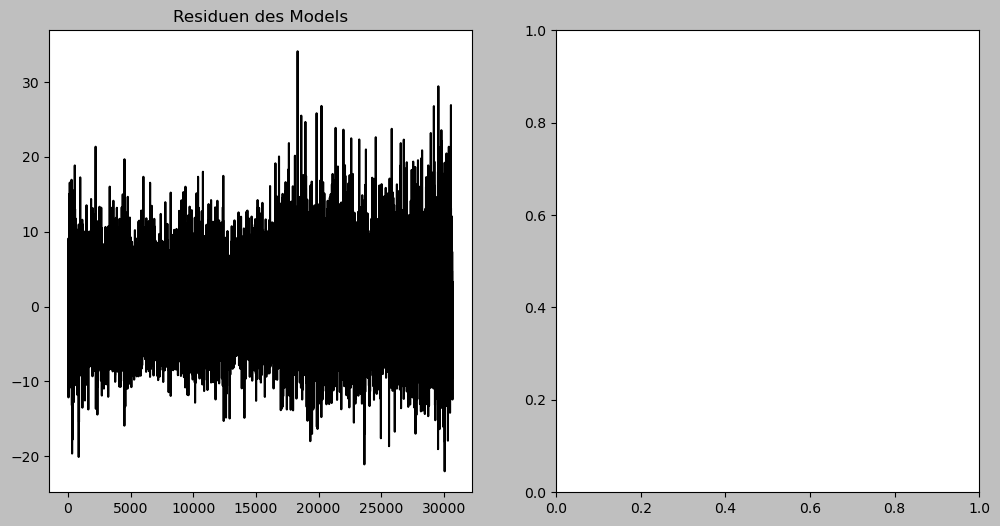

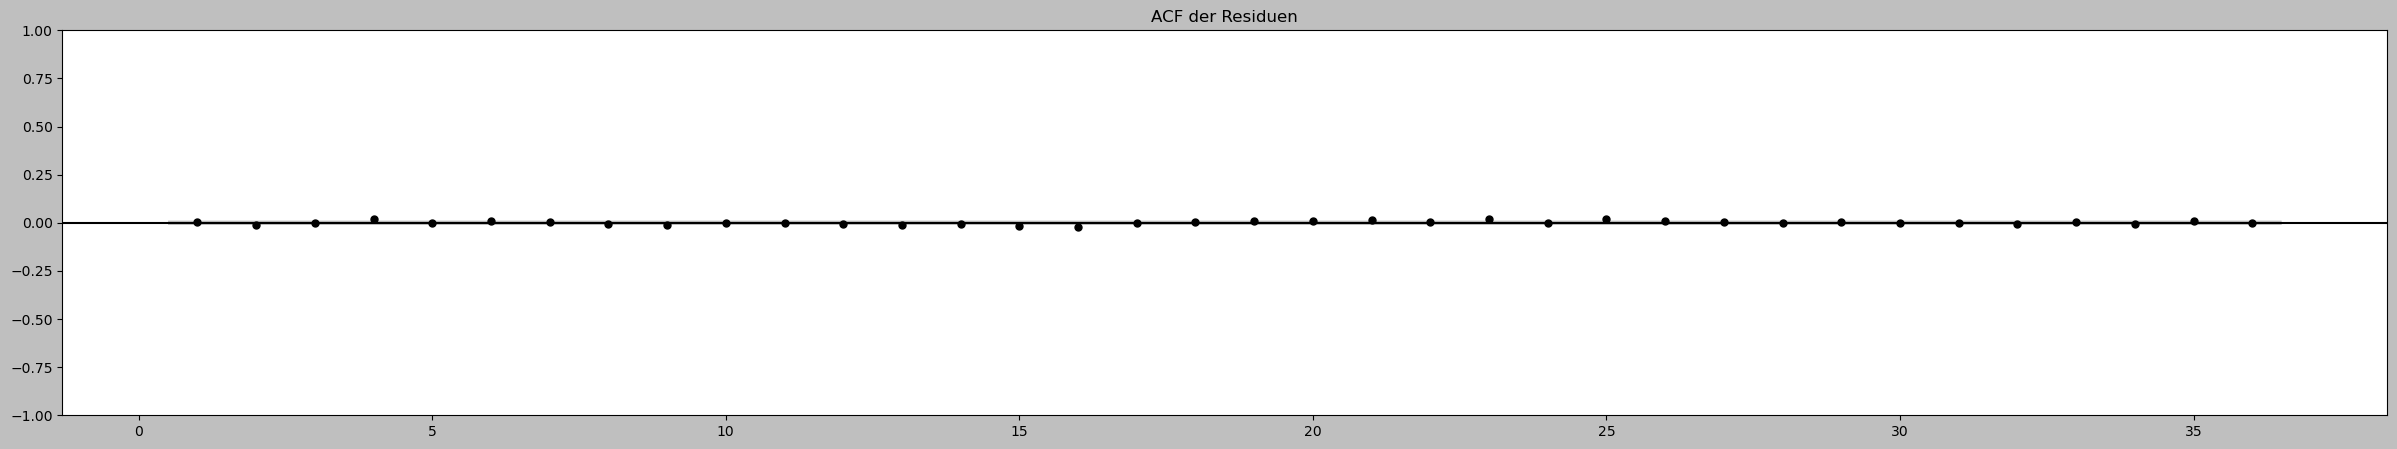

In [6]:
# Werte aus HPO mit Optuna
sarima_model_hourly = SARIMAX(hourly_diff_24, 
                order=(1,1,2), 
                seasonal_order=(1,0,1,24)).fit(disp=False)
print(sarima_model_hourly.summary())

# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = sarima_model_hourly.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Models")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()


1. Allgemeiner Überblick:
Modell 1: SARIMAX(1, 0, 1) x (1, 1, [1, 2], 24)
Modell 2: SARIMAX(1, 1, 2) x (1, 0, [1], 24)
Die Hauptunterschiede zwischen den Modellen sind:

Modell 1 verwendet eine saisonale Differenzierung (D=1), während Modell 2 eine nicht-saisonale Differenzierung (d=1) nutzt.
Modell 1 hat eine komplexere saisonale Komponente mit zwei Moving-Average-Elementen ([1, 2]), während Modell 2 nur eines ([1]) verwendet.
2. Akaike-Informationskriterium (AIC):
Modell 1: AIC = 176477.001
Modell 2: AIC = 176166.523
Modell 2 hat einen niedrigeren AIC-Wert, was bedeutet, dass es besser geeignet ist, die Daten mit weniger Overfitting zu modellieren.

3. Bayesianisches Informationskriterium (BIC):
Modell 1: BIC = 176526.983
Modell 2: BIC = 176216.510
Auch hier schneidet Modell 2 besser ab, was darauf hinweist, dass es insgesamt sparsamer und wahrscheinlich besser verallgemeinerbar ist.

4. Log-Likelihood:
Modell 1: Log-Likelihood = -88232.501
Modell 2: Log-Likelihood = -88077.262
Modell 2 erreicht eine höhere Log-Likelihood, was bedeutet, dass es die Daten besser erklärt.

5. Parameter-Schätzung und Signifikanz:
Beide Modelle zeigen signifikante Parameter (P-Werte < 0.05).
Die saisonalen MA-Komponenten (z. B. ma.S.L24 und ma.S.L48 in Modell 1 bzw. ma.S.L24 in Modell 2) haben bei beiden Modellen hohe Absolutwerte und sind entscheidend für die Modellierung.
6. Residuenanalyse:
Ljung-Box-Test (L1):
Modell 1: 
𝑝
=
0.67
p=0.67
Modell 2: 
𝑝
=
0.54
p=0.54
Beide Modelle haben unkorrelierte Residuen (p > 0.05).

Jarque-Bera-Test:
Modell 1 und Modell 2 haben hohe JB-Werte, was auf nicht-normal verteilte Residuen hinweist.
7. Varianz (Heteroskedastizität):
Modell 1: H = 1.74
Modell 2: H = 1.75
Beide Modelle zeigen Heteroskedastizität (p < 0.05), was möglicherweise durch Modellerweiterungen wie GARCH angegangen werden könnte.

## Vorbereitung von df_daily für SARIMAX

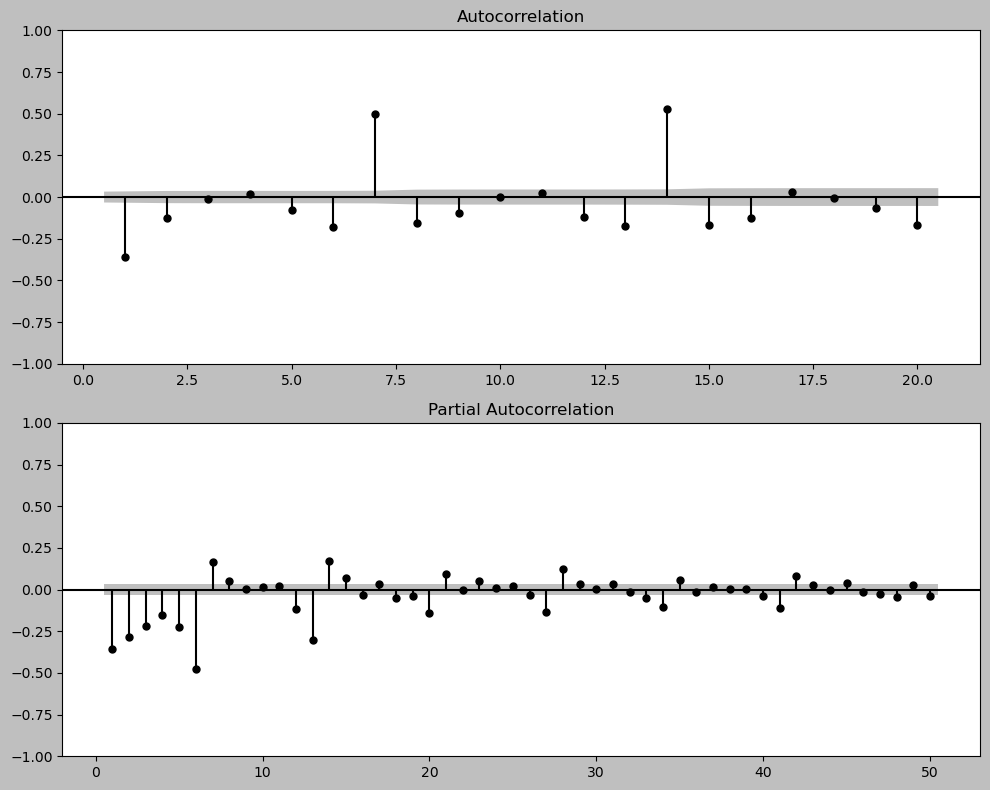

In [7]:
# ACF und PACF
# Nur die Spalte 'calls' auswählen und Differenz berechnen
daily_diff = df_daily['calls'].diff().dropna()

# ACF und PACF Plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(daily_diff, zero=False, lags=20, ax=ax[0])
plot_pacf(daily_diff, zero=False, lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

In [8]:
# Datensatz stationär werden lassen 
# Anwendung auf df_daily
daily_diff_7 = df_daily['calls'].diff(7).dropna()
check_stationarity(daily_diff_7)

'Stationary	 p-value:2.4490544761315032e-23 	 lags:28


('Stationary', 2.4490544761315032e-23)

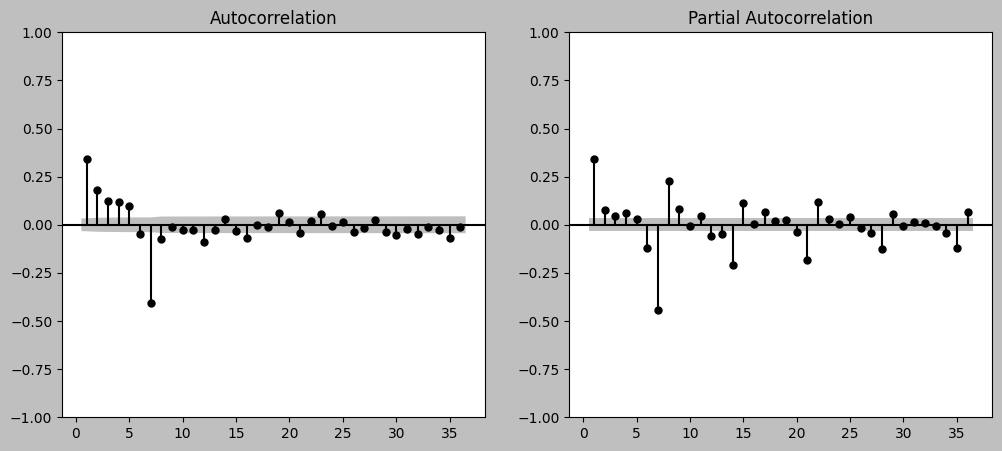

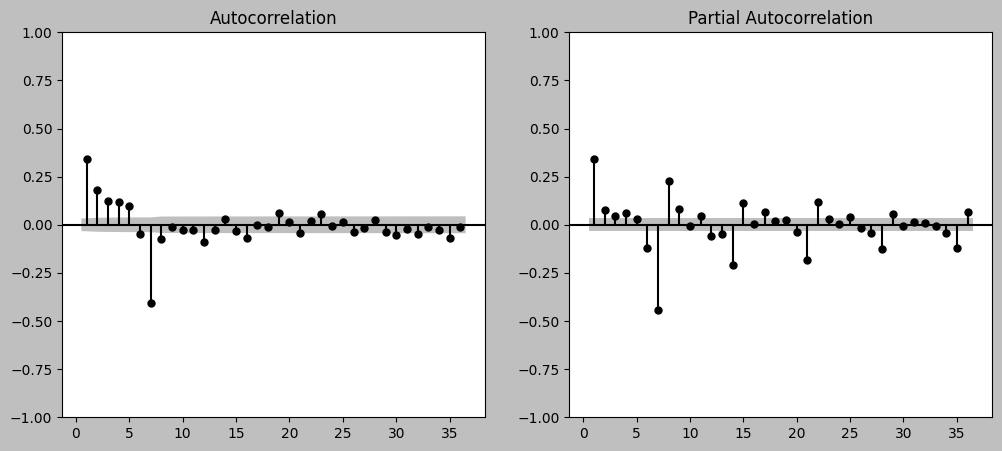

In [22]:
fig, ax = plt.subplots(1,2)
plot_acf(daily_diff_7, zero=False, ax=ax[0], lags=36)
plot_pacf(daily_diff_7, zero=False, ax=ax[1], lags=36)

In [23]:
ljung_box_result = acorr_ljungbox(daily_diff_7, lags=[10, 20, 30], return_df=True)
print(ljung_box_result)

        lb_stat      lb_pvalue
10  1298.013737  1.026514e-272
20  1370.588213  2.235701e-278
30  1415.835599  3.335950e-279


Das Ergebnis des Ljung-Box-Tests zeigt, dass die p-Werte für alle getesteten Lags (10, 20, 30) extrem klein sind (z.B. 1.026×10−2721.026×10−272). Das bedeutet, dass die Nullhypothese, dass die Residuen unkorreliert sind (weißes Rauschen), abgelehnt werden muss. Es gibt also weiterhin signifikante Autokorrelationen in den Residuen. (ChatGPT)

In [24]:
daily_diff_7_1 = daily_diff_7.diff(1).dropna()
check_stationarity(daily_diff_7_1)

'Stationary	 p-value:2.0242717172131786e-30 	 lags:30


('Stationary', np.float64(2.0242717172131786e-30))

Das Ergebnis zeigt, dass der Datensatz nach der zusätzlichen Differenzierung (zum Beispiel mit daily_diff_7.diff(1)) weiterhin stationär ist. Der p-Wert (2.02×10−302.02×10−30) ist extrem klein, was darauf hindeutet, dass die Nullhypothese des Augmented Dickey-Fuller-Tests abgelehnt wird. Dies bestätigt, dass keine Trends oder saisonalen Muster mehr im differenzierten Datensatz vorhanden sind.

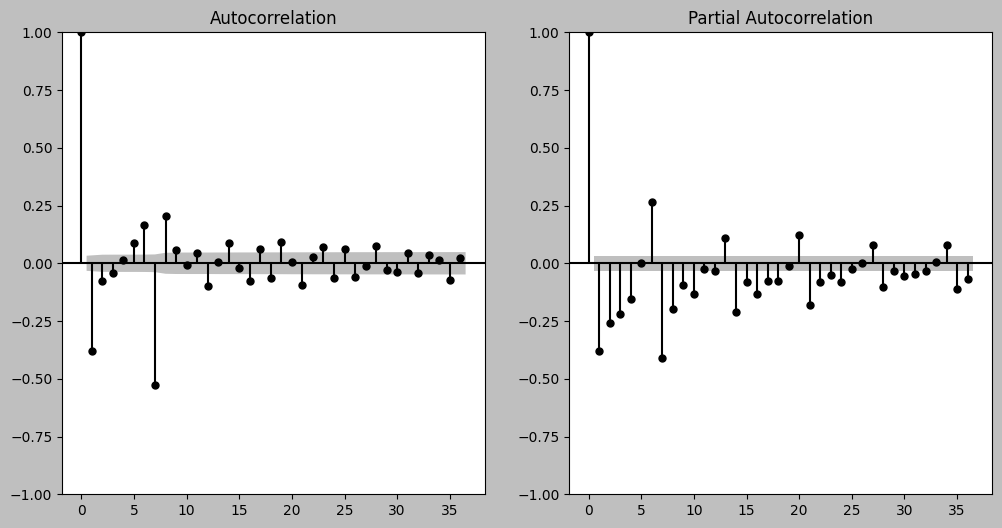

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(daily_diff_7_1, lags=36, ax=ax[0])
plot_pacf(daily_diff_7_1, lags=36, ax=ax[1])
plt.show()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: C

                                     SARIMAX Results                                     
Dep. Variable:                             calls   No. Observations:                 3586
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -18045.832
Date:                           Wed, 05 Feb 2025   AIC                          36107.664
Time:                                   09:40:40   BIC                          36157.140
Sample:                                        0   HQIC                         36125.300
                                          - 3586                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9296      0.009     98.360      0.000       0.911       0.948
ma.L1         -1.6116      0.016   -101.139

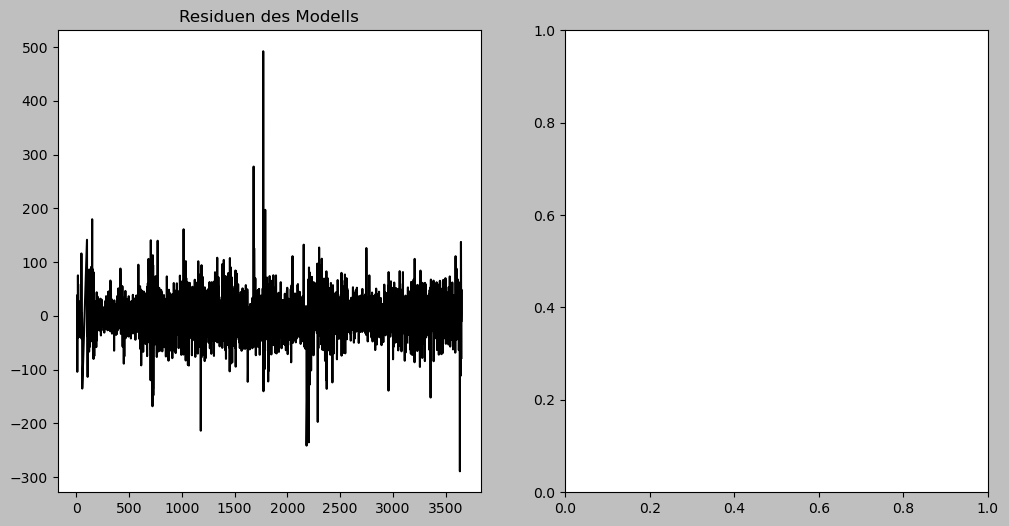

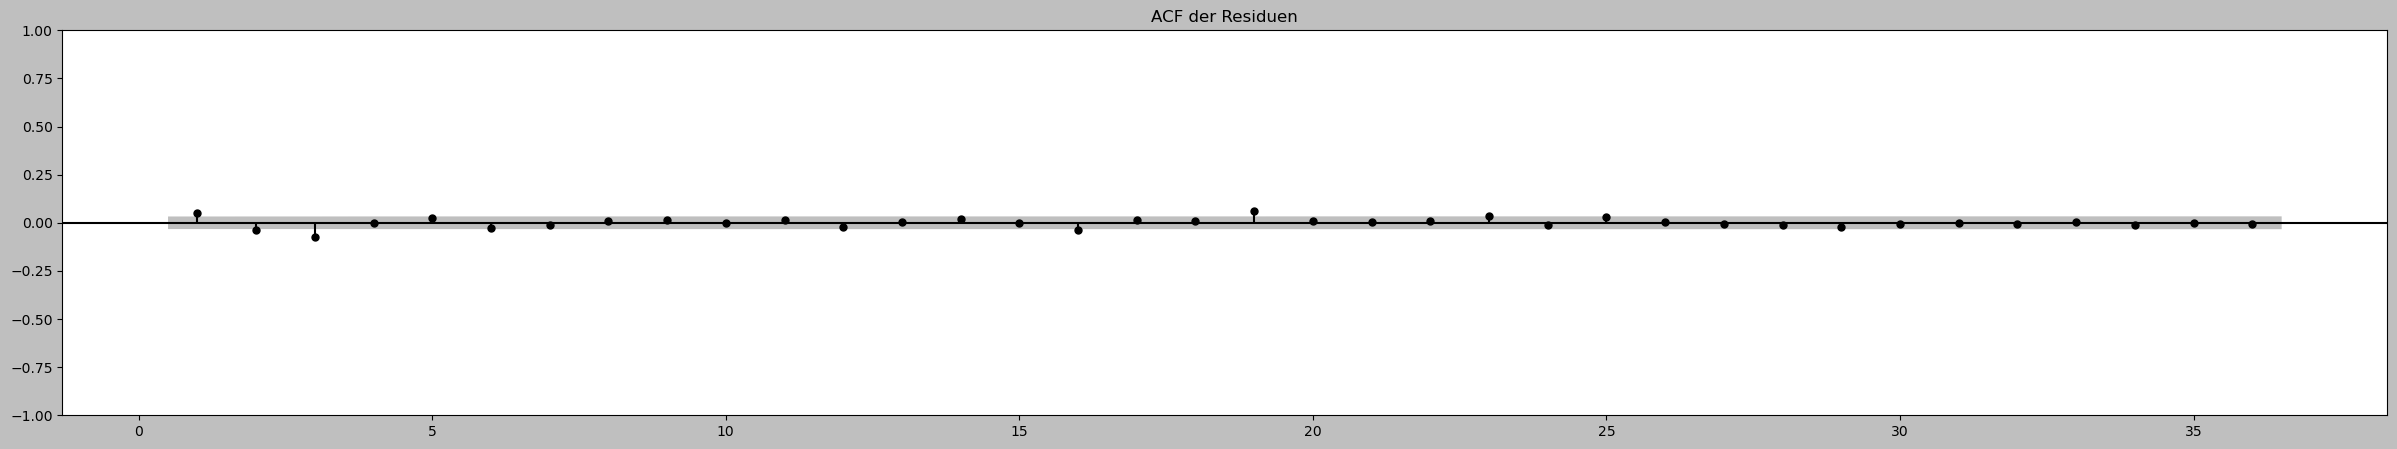

In [9]:

# SARIMA Modell mit HPO für df_daily
sarima_model_daily = SARIMAX(daily_diff_7, 
                order=(1, 1, 2), 
                seasonal_order=(2, 0, 2, 7)).fit(disp=False)

print(sarima_model_daily.summary())

# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = sarima_model_daily.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

Das Modell ist nicht schlecht, liefert aber auch keine super Ergbenisse. Außerdem ist bei dem zugehörigen ACF Plot weiterhin ein zyklischer Ausreißer zu sehen, bei Lag = 7 und 14. Wir testen nun das Modell mit daily_diff_7, also mit einer Differenzierung weniger.

In [ ]:
# SARIMA Modell für df_daily
model = SARIMAX(daily_diff_7, 
                order=(1, 0, 1), 
                seasonal_order=(1, 1, 1, 7)).fit(disp=False)

print(model.summary())

# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

NameError: name 'SARIMAX' is not defined

Im Vergleich dazu schneidet dieses Modell in allen Kriterien deutlich besser ab und kann als solides Modell bezeichnet werden. Es bleibt weiterhin das Problem, dass im ACF Plot die zyklischen Ausreißer bei 7 und 14 zu finden sind. Als nächsten Schritt wird jetzt den saisonalen Parametern mehr Gewichtung gegeben. 

                                       SARIMAX Results                                        
Dep. Variable:                                  calls   No. Observations:                 3586
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 7)   Log Likelihood              -18062.136
Date:                                Mon, 06 Jan 2025   AIC                          36138.273
Time:                                        12:02:09   BIC                          36181.553
Sample:                                             0   HQIC                         36153.701
                                               - 3586                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9321      0.008    117.887      0.000       0.917       0.948
ma.

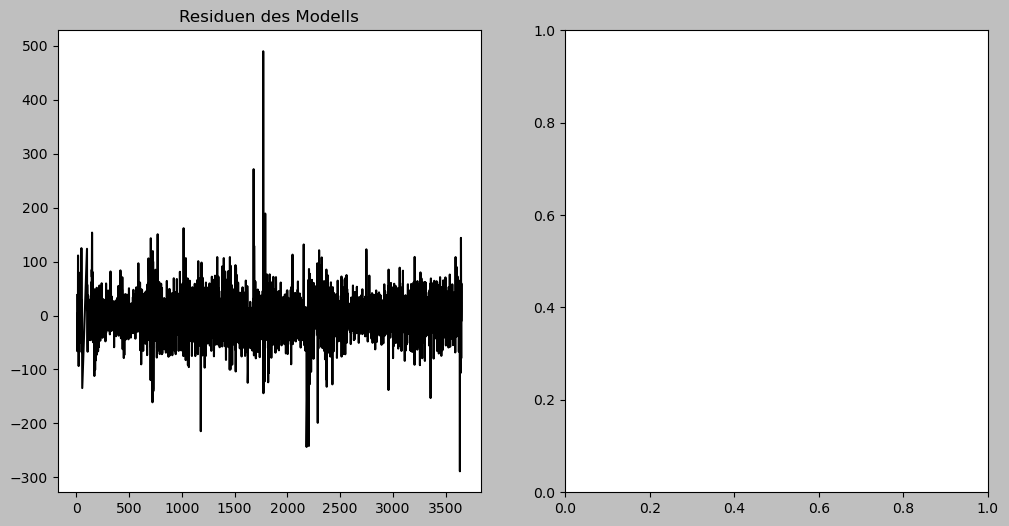

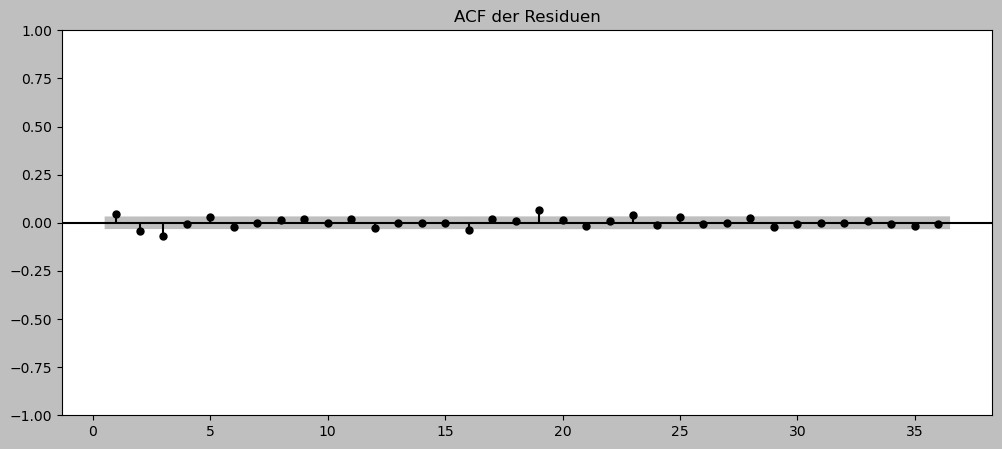

In [ ]:
# SARIMA Modell für df_daily
model = SARIMAX(daily_diff_7, 
                order=(1, 0, 1), 
                seasonal_order=(2, 1, 2, 7)).fit(disp=False)

print(model.summary())

# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

Das scheint bisher das beste Modell zu sein.

                                     SARIMAX Results                                     
Dep. Variable:                             calls   No. Observations:                 3586
Model:             SARIMAX(1, 0, 1)x(1, 2, 1, 7)   Log Likelihood                -706.318
Date:                           Mon, 06 Jan 2025   AIC                           1422.636
Time:                                   11:10:00   BIC                           1453.541
Sample:                                        0   HQIC                          1433.654
                                          - 3586                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999   6.75e-07   1.48e+06      0.000       1.000       1.000
ma.L1         -0.9996      0.001  -1804.673

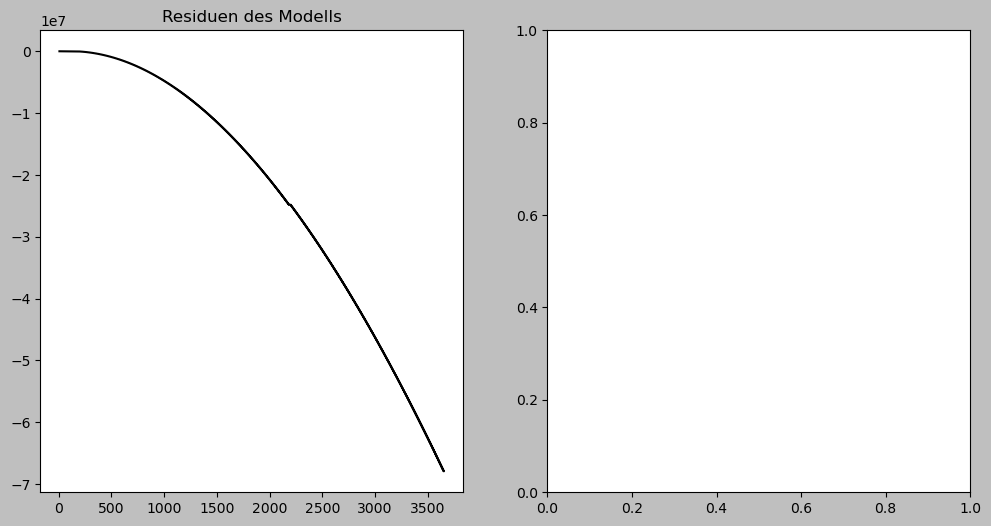

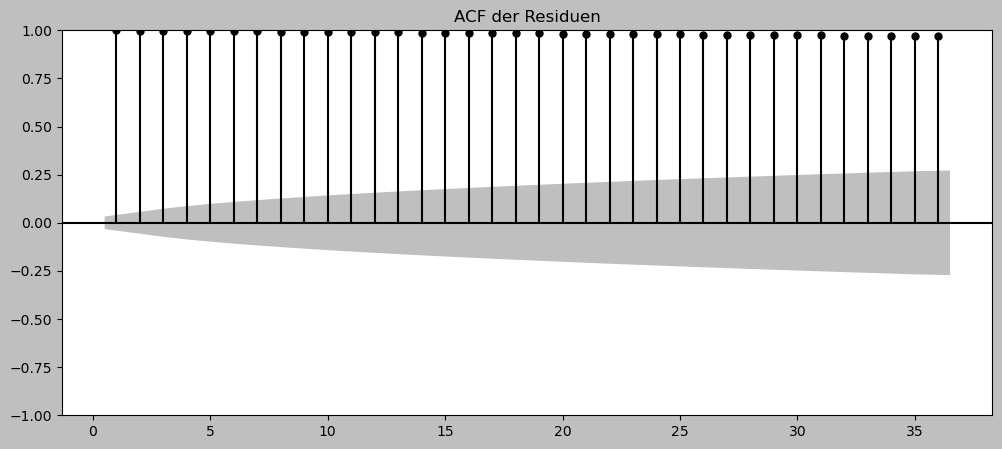

In [30]:
# SARIMA Modell für df_daily
model = SARIMAX(daily_diff_7, 
                order=(1, 0, 1), 
                seasonal_order=(1, 2, 1, 7)).fit(disp=False)

print(model.summary())
# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

Den Test D auf 2 zu erhöhen, um komplexere Muster einzubinden, hat nicht funktioniert. Bereits am ACF Plot sieht man, dass die Werte stark von den erwarteten abweichen.

                                       SARIMAX Results                                        
Dep. Variable:                                  calls   No. Observations:                 3604
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 7)   Log Likelihood              -18042.944
Date:                                Mon, 06 Jan 2025   AIC                          36099.888
Time:                                        12:08:01   BIC                          36143.203
Sample:                                             0   HQIC                         36115.325
                                               - 3604                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2044      0.019     10.516      0.000       0.166       0.242
ma.

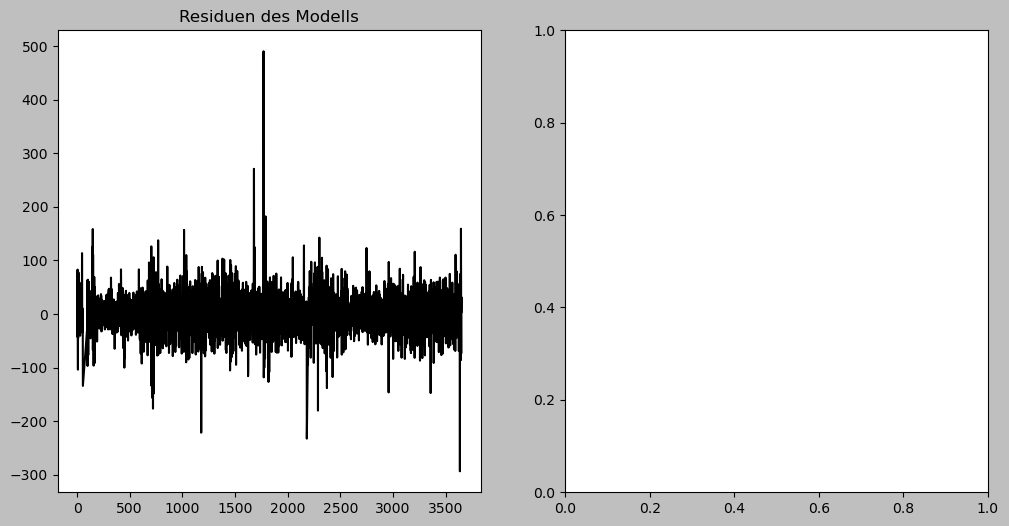

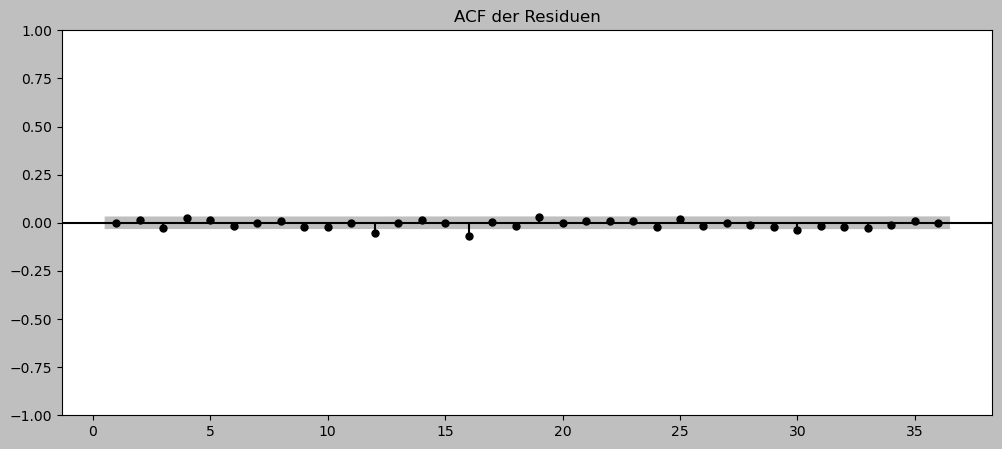

In [34]:
# SARIMA Modell für df_daily
model = SARIMAX(daily_diff, 
                order=(1, 0, 1), 
                seasonal_order=(2, 1, 2, 7)).fit(disp=False)

print(model.summary())
# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

### Hyperparameteroptimierung mit Optuna

In [37]:
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
def objective(trial, data, s):
    # Hyperparameter-Räume definieren
    p = trial.suggest_int("p", 0, 2)
    d = trial.suggest_int("d", 0, 1)  # Stationarity: meist nur 0 oder 1 sinnvoll
    q = trial.suggest_int("q", 0, 2)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)  # Saisonale Differenzierung: meist 0 oder 1 sinnvoll
    Q = trial.suggest_int("Q", 0, 2)

    try:
        # SARIMA-Modell trainieren
        model = SARIMAX(data, order=(p, d, q),
                        seasonal_order=(P, D, Q, s)).fit(disp=False)
        # Optimierung basierend auf dem Akaike-Informationskriterium (AIC)
        return model.aic
    except Exception as e:
        # Rückgabe von "unendlich", falls das Modell fehlschlägt
        return float("inf")

# Funktion zur Optimierung für unterschiedliche Datensätze und saisonale Werte
def optimize_sarima(data, s, n_trials=50):
    print(f"Starte Optimierung für s={s} mit {n_trials} Trials...")
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, data, s), n_trials=n_trials)
    print("Beste Parameter:", study.best_params)
    return study.best_params

In [ ]:

# Beispiel: Optimierung für hourly_diff_24 und daily_diff_7
best_params_hourly = optimize_sarima(df_hourly, s=24, n_trials=50)
best_params_daily = optimize_sarima(df_daily, s=7, n_trials=50)

print("Optimale Parameter für hourly_diff_24:", best_params_hourly)
print("Optimale Parameter für daily_diff_7:", best_params_daily)

[I 2025-01-14 22:31:12,722] A new study created in memory with name: no-name-555e745d-7417-4172-a23e-78da9007cf06


Starte Optimierung für s=24 mit 50 Trials...


[I 2025-01-14 22:31:20,382] Trial 0 finished with value: 230774.54062797411 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 0}. Best is trial 0 with value: 230774.54062797411.
[I 2025-01-14 22:36:49,880] Trial 1 finished with value: 176199.13834692724 and parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 2, 'D': 0, 'Q': 1}. Best is trial 1 with value: 176199.13834692724.
[I 2025-01-14 23:07:07,899] Trial 2 finished with value: 177974.45511738845 and parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 2}. Best is trial 1 with value: 176199.13834692724.
[I 2025-01-14 23:07:32,157] Trial 3 finished with value: 212604.180229676 and parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 1, 'D': 1, 'Q': 0}. Best is trial 1 with value: 176199.13834692724.
[I 2025-01-14 23:08:57,411] Trial 4 finished with value: 183825.80544583633 and parameters: {'p': 1, 'd': 1, 'q': 0, 'P': 2, 'D': 0, 'Q': 1}. Best is trial 1 with value: 176199.13834692724.
[I 2025-01-14 23:09:17,159] Trial 5 finished with va

Beste Parameter: {'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 1}
Starte Optimierung für s=7 mit 50 Trials...


[I 2025-01-15 00:47:09,920] Trial 0 finished with value: 36322.68494775261 and parameters: {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 1}. Best is trial 0 with value: 36322.68494775261.
[I 2025-01-15 00:47:11,738] Trial 1 finished with value: 37828.54093746451 and parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 0 with value: 36322.68494775261.
[I 2025-01-15 00:47:11,900] Trial 2 finished with value: 41673.00939240945 and parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 0, 'D': 1, 'Q': 0}. Best is trial 0 with value: 36322.68494775261.
[I 2025-01-15 00:47:15,925] Trial 3 finished with value: 36959.00612344383 and parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 1}. Best is trial 0 with value: 36322.68494775261.
[I 2025-01-15 00:47:16,526] Trial 4 finished with value: 37325.53817580859 and parameters: {'p': 2, 'd': 1, 'q': 0, 'P': 1, 'D': 0, 'Q': 0}. Best is trial 0 with value: 36322.68494775261.
[I 2025-01-15 00:47:16,810] Trial 5 finished with value: 374

Beste Parameter: {'p': 1, 'd': 1, 'q': 2, 'P': 2, 'D': 0, 'Q': 2}
Optimale Parameter für hourly_diff_24: {'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 1}
Optimale Parameter für daily_diff_7: {'p': 1, 'd': 1, 'q': 2, 'P': 2, 'D': 0, 'Q': 2}


In [1]:
# Ergebnisse der SARIMA-Optimierung
best_params_hourly = {'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 1}
best_params_daily = {'p': 1, 'd': 1, 'q': 2, 'P': 2, 'D': 0, 'Q': 2}


# Erstellen des kombinierten DataFrames
best_params_sarima = pd.DataFrame(
    [best_params_hourly, best_params_daily], 
    index=["df_hourly", "df_daily"]
)

In [14]:
# Speicherung des kombinierten DataFrames
best_params_sarima.to_csv("best_params_sarima.csv")
daily_diff_7.to_csv("df_daily_diff_7.csv")
hourly_diff_24.to_csv("hourly_diff_24.csv")

# Neue Berechnung mit df_daily und df_hourly direkt

In [ ]:
df_daily = df_daily.drop(columns=["Unnamed: 0"])  # Unnötige Spalte löschen
df_daily["date"] = pd.to_datetime(df_daily["date"])  # Falls noch nicht im Datetime-Format
df_daily = df_daily.set_index("date")  # Datum als Index setzen
df_daily["weekday"] = df_daily.index.dayofweek  # Montag=0, Sonntag=6

In [ ]:
df_hourly = df_hourly.drop(columns=["Unnamed: 0"])  # Unnötige Spalte löschen
df_hourly["date"] = pd.to_datetime(df_hourly["date"])  # Falls noch nicht im Datetime-Format
df_hourly = df_hourly.set_index("date")  # Datum als Index setzen
df_hourly["weekday"] = df_hourly.index.dayofweek  # Montag=0, Sonntag=6

In [40]:
df_daily_test = df_daily_test.drop(columns=["Unnamed: 0"])  # Unnötige Spalte löschen
df_daily_test["date"] = pd.to_datetime(df_daily_test["date"])  # Falls noch nicht im Datetime-Format
df_daily_test = df_daily_test.set_index("date")  # Datum als Index setzen
df_daily_test["weekday"] = df_daily_test.index.dayofweek  # Montag=0, Sonntag=6

In [ ]:
df_daily_test = df_daily_test.drop(columns=["Unnamed: 0"])  # Unnötige Spalte löschen
df_daily_test["date"] = pd.to_datetime(df_daily_test["date"])  # Falls noch nicht im Datetime-Format
df_daily_test = df_daily_test.set_index("date")  # Datum als Index setzen
df_daily_test["weekday"] = df_daily_test.index.dayofweek  # Montag=0, Sonntag=6

df_hourly_test = df_hourly_test.drop(columns=["Unnamed: 0"])  # Unnötige Spalte löschen
df_hourly_test["date"] = pd.to_datetime(df_hourly_test["date"])  # Falls noch nicht im Datetime-Format
df_hourly_test = df_hourly_test.set_index("date")  # Datum als Index setzen
df_hourly_test["weekday"] = df_hourly_test.index.dayofweek  # Montag=0, Sonntag=6

In [42]:
df_daily_test

,calls,days_to_holiday,forecast,weekday
date,,,,
2024-01-01,211,0,397.580716,0
2024-01-02,417,-1,371.312805,1
2024-01-03,399,-2,365.230182,2
2024-01-04,388,-3,349.225624,3
2024-01-05,332,-4,342.664150,4
...,...,...,...,...
2024-06-26,444,-56,373.838014,2
2024-06-27,407,-57,359.500605,3
2024-06-28,412,-58,352.099682,4


In [39]:
df_daily_test

,Unnamed: 0,date,calls,days_to_holiday,forecast
0,0,2024-01-01,211,0,397.580716
1,1,2024-01-02,417,-1,371.312805
2,2,2024-01-03,399,-2,365.230182
3,3,2024-01-04,388,-3,349.225624
4,4,2024-01-05,332,-4,342.664150
...,...,...,...,...,...
177,177,2024-06-26,444,-56,373.838014
178,178,2024-06-27,407,-57,359.500605
179,179,2024-06-28,412,-58,352.099682
180,180,2024-06-29,363,-59,291.119907


In [70]:
# Sicherstellen, dass der Index von df_hourly ein DatetimeIndex ist
df_hourly.index = pd.to_datetime(df_hourly.index)

# Slice des DataFrames ab dem Index Juli 2020
df_hourly_time_modified = df_hourly[df_hourly.index >= '2022-01-01']

In [71]:
# SARIMA Modell für df_hourly
sarima_model_hourly = SARIMAX(df_hourly_time_modified['calls'], 
                order=(1, 1, 1), 
                seasonal_order=(2, 1, 2, 24),
                exog=df_hourly_time_modified[['days_to_holiday', 'weekday']]).fit(disp=False)

print(model.summary())
# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

MemoryError: Unable to allocate 752. MiB for an array with shape (75, 75, 17520) and data type float64

                                       SARIMAX Results                                        
Dep. Variable:                                  calls   No. Observations:                 3652
Model:             SARIMAX(2, 0, 1)x(2, 1, [1, 2], 7)   Log Likelihood              -17987.440
Date:                                Mon, 17 Feb 2025   AIC                          35990.879
Time:                                        10:13:00   BIC                          36040.488
Sample:                                             0   HQIC                         36008.548
                                               - 3652                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1666      0.023     51.769      0.000       1.122       1.211
ar.

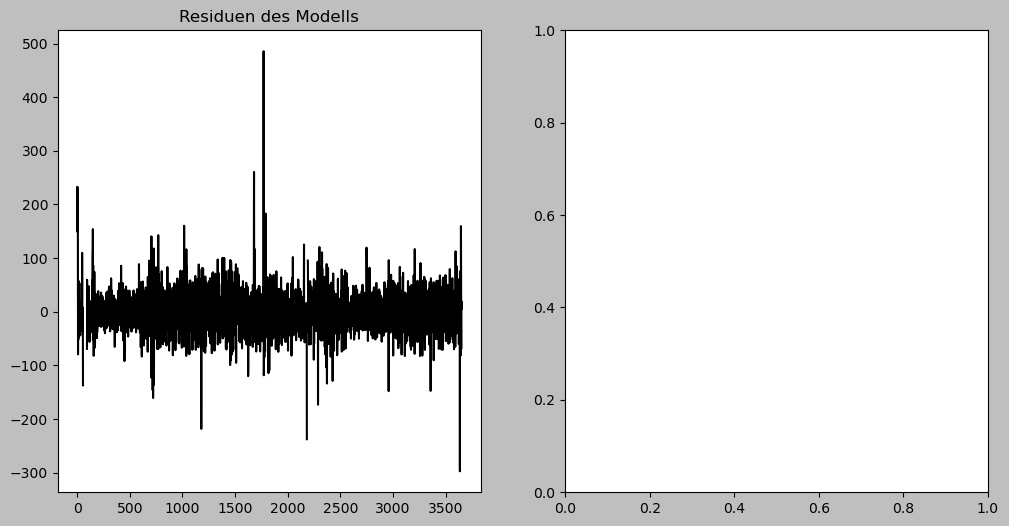

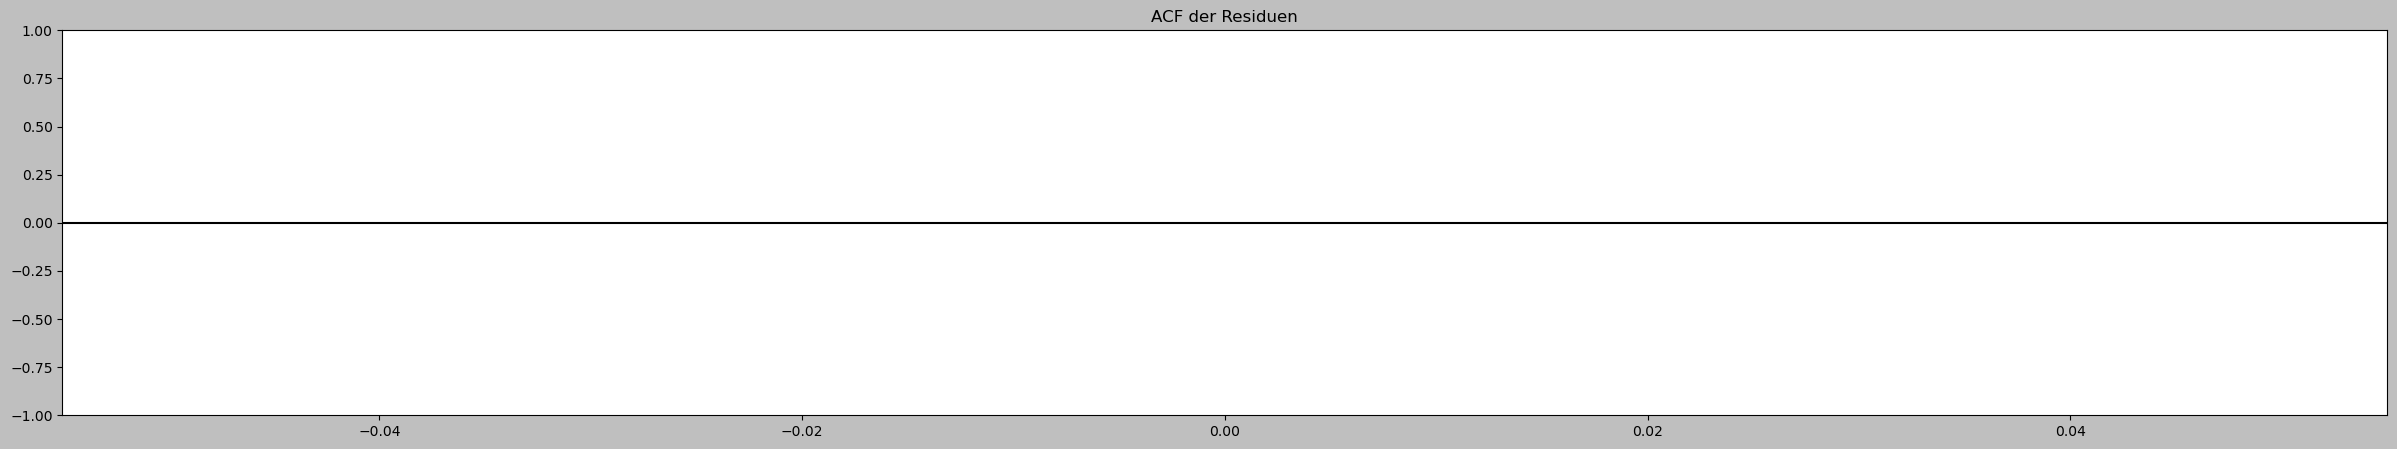

In [32]:
# SARIMA Modell für df_daily
sarima_model_daily = SARIMAX(df_daily['calls'], 
                order=(2, 1, 1), 
                seasonal_order=(2, 1, 2, 7),
                exog=df_daily[['days_to_holiday', 'weekday']]).fit(disp=False)

print(model.summary())
# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

In [64]:
# Sicherstellen, dass der Index von df_daily ein DatetimeIndex ist
df_daily.index = pd.to_datetime(df_daily.index)

# Slice des DataFrames ab dem Index Juli 2020
df_daily_july_2020 = df_daily[df_daily.index >= '2022-01-01']

In [ ]:
df_daily

,calls,days_to_holiday,weekday
date,,,
2020-07-01,213.0,-61,2
2020-07-02,256.0,-62,3
2020-07-03,238.0,-63,4
2020-07-04,312.0,-64,5
2020-07-05,293.0,64,6
...,...,...,...
2023-12-27,405.0,-2,2
2023-12-28,372.0,-3,3
2023-12-29,363.0,3,4


                                       SARIMAX Results                                        
Dep. Variable:                                  calls   No. Observations:                 3652
Model:             SARIMAX(2, 0, 1)x(2, 1, [1, 2], 7)   Log Likelihood              -17987.440
Date:                                Mon, 17 Feb 2025   AIC                          35990.879
Time:                                        13:19:01   BIC                          36040.488
Sample:                                             0   HQIC                         36008.548
                                               - 3652                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1666      0.023     51.769      0.000       1.122       1.211
ar.

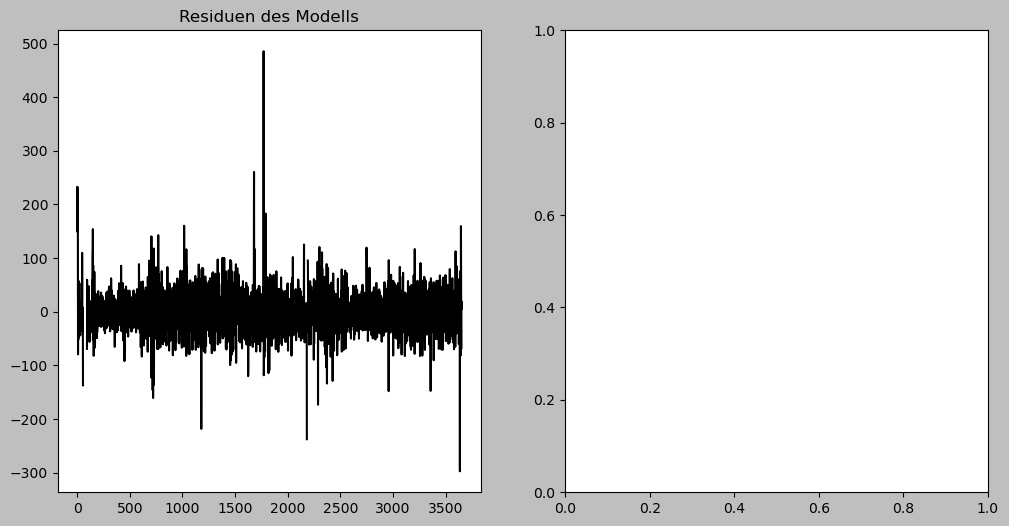

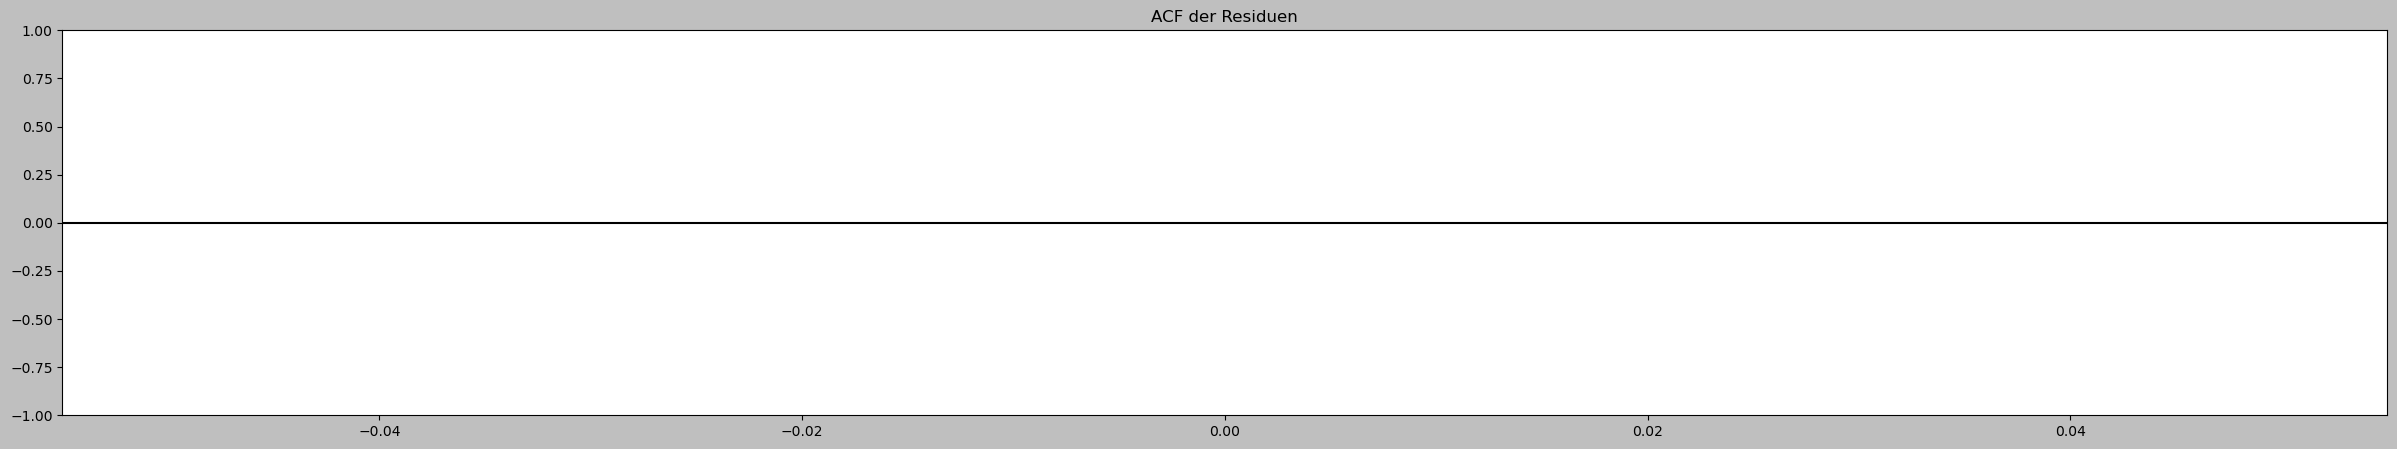

In [65]:
# SARIMA Modell für df_daily
sarima_model_daily = SARIMAX(df_daily_july_2020['calls'], 
                order=(2, 1, 1), 
                seasonal_order=(2, 1, 2, 7),
                exog=df_daily_july_2020[['days_to_holiday', 'weekday']]).fit(disp=False)

print(model.summary())
# Plot der Residuen
# Die Residuen sollten keine offensichtliche Struktur mehr haben (zufällig um 0 verteilt).
# Die ACF der Residuen sollte für alle Lags innerhalb des Konfidenzintervalls (grauer Bereich) liegen.
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title("Residuen des Modells")
plt.subplot(122)
plot_acf(residuals, zero=False, lags=36)
plt.title("ACF der Residuen")
plt.show()

## Forecast für 2024

In [66]:
forecast_steps_daily = len(df_daily_test)  # Anzahl der Tage im Testzeitraum
forecast_steps_hourly = len(df_hourly_test)  # Anzahl der Stunden im Testzeitraum

In [67]:
# Zukünftige Werte für exogene Variablen bereitstellen
future_exog = df_daily_test[['days_to_holiday', 'weekday']].values  # Muss dieselbe Struktur haben wie beim Training

# Forecast mit exogenen Variablen
forecast_daily = sarima_model_daily.forecast(steps=forecast_steps_daily, exog=future_exog)

# Speichern im DataFrame
df_daily_test["forecast"] = forecast_daily.values

forecast_hourly = sarima_model_hourly.forecast(steps=forecast_steps_hourly)
df_hourly_test["forecast"] = forecast_hourly.values

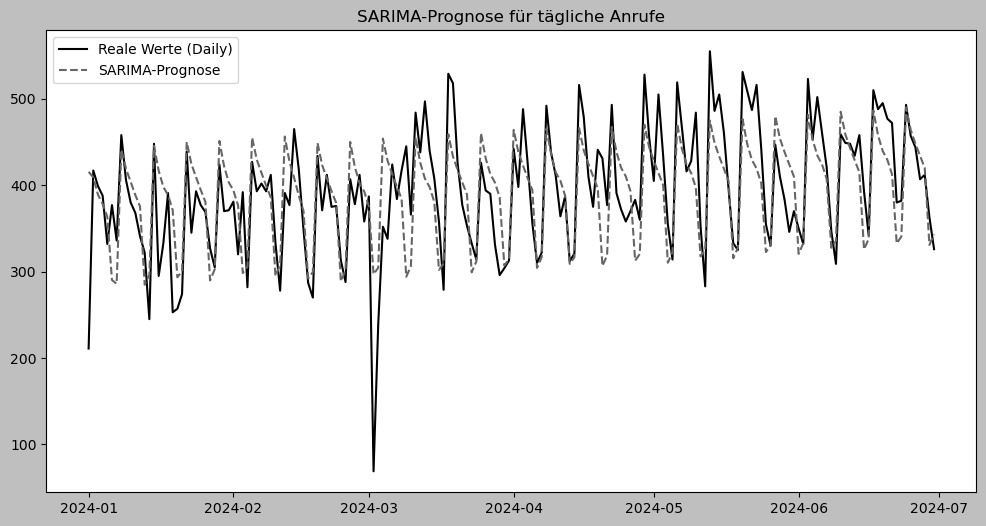

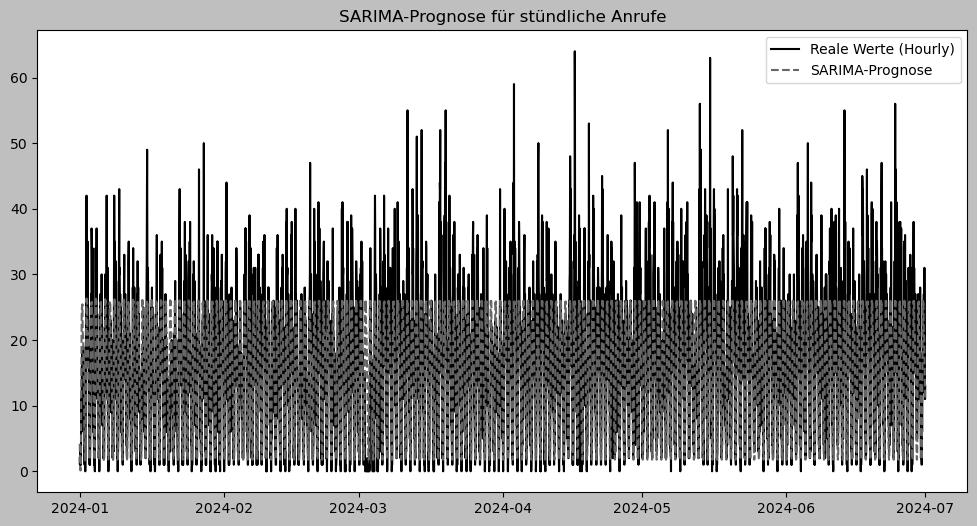

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(df_daily_test.index, df_daily_test["calls"], label="Reale Werte (Daily)")
plt.plot(df_daily_test.index, df_daily_test["forecast"], label="SARIMA-Prognose", linestyle="dashed")
plt.legend()
plt.title("SARIMA-Prognose für tägliche Anrufe")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_hourly_test.index, df_hourly_test["calls"], label="Reale Werte (Hourly)")
plt.plot(df_hourly_test.index, df_hourly_test["forecast"], label="SARIMA-Prognose", linestyle="dashed")
plt.legend()
plt.title("SARIMA-Prognose für stündliche Anrufe")
plt.show()

In [85]:
# Trainiere das SARIMA-Modell
sarima_fitted = sarima_model_hourly.fit()

# Berechne die Residuen (Fehler der Vorhersage)
residuals_hourly = sarima_fitted.resid

# Speichere die Residuen für GARCH
residuals_hourly.to_pickle("residuals_hourly.pkl")

# Plot der Residuen zur Kontrolle
plt.figure(figsize=(10,4))
plt.plot(residuals_hourly, label="Residuen")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("SARIMA Residuen")
plt.legend()
plt.show()

AttributeError: 'SARIMAXResults' object has no attribute 'fit'

In [84]:
from datetime import datetime
plt.figure(figsize=(100, 6))

# Trennpunkt: Jahresende 2019
split_date = datetime.strptime("2019-12-31", "%Y-%m-%d")

# In-Sample-Vorhersage für Trainingsdaten
train_forecast = sarima_model_daily.fittedvalues

# Out-of-Sample-Vorhersage für Testdaten
future_exog = df_daily_test[['days_to_holiday', 'weekday']].values  
test_forecast = sarima_model_daily.forecast(steps=len(df_daily_test), exog=future_exog)

# Trainingsdaten plotten
plt.plot(df_daily_july_2020.index, df_daily_july_2020["calls"], label="Trainingsdaten", color="blue")
plt.plot(df_daily_july_2020.index, train_forecast, label="SARIMA Prognose (Train)", color="cyan", linestyle="dashed")

# Testdaten plotten
plt.plot(df_daily_test.index, df_daily_test["calls"], label="Testdaten", color="green")
plt.plot(df_daily_test.index, test_forecast, label="SARIMA Prognose (Test)", color="red", linestyle="dashed")

# Vertikale Linie zur Trennung von Trainings- und Testdaten
plt.axvline(x=split_date, color="black", linestyle="--", label="Split 2019-12-31")

plt.title("Vergleich: Trainings- vs. Testdaten mit SARIMA Prognose")
plt.xlabel("Datum")
plt.ylabel("Anrufanzahl")
plt.legend()
plt.show()


AttributeError: 'NoneType' object has no attribute 'squeeze'

<Figure size 10000x600 with 0 Axes>

In [79]:
df_daily_test

,calls,days_to_holiday,forecast,weekday
date,,,,
2024-01-01,211,0,415.484773,0
2024-01-02,417,-1,409.125649,1
2024-01-03,399,-2,389.039367,2
2024-01-04,388,-3,378.416145,3
2024-01-05,332,-4,363.404011,4
...,...,...,...,...
2024-06-26,444,-56,448.179687,2
2024-06-27,407,-57,434.133068,3
2024-06-28,412,-58,419.952552,4


# Berechnung der Güte mit Fehlermetriken

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Annahme: Du hast die tatsächlichen Werte in df_daily_test['calls'] und die Vorhersagen in df_daily_test['forecast'] (SARIMA Vorhersagen)
# WERTE FÜR DAILY
# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(df_daily_test['calls'], df_daily_test['forecast'])

# 2. MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((df_daily_test['calls'] - df_daily_test['forecast']) / df_daily_test['calls'])) * 100

# 3. MSE (Mean Squared Error)
mse = mean_squared_error(df_daily_test['calls'], df_daily_test['forecast'])

# 4. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Ergebnisse ausgeben
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 37.6172
MAPE: 11.4623%
MSE: 2542.8454
RMSE: 50.4266


In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Annahme: Du hast die tatsächlichen Werte in df_hourly_test['calls'] und die Vorhersagen in df_hourly_test['forecast'] (SARIMA Vorhersagen)

# WERTE FÜR HOURLY

# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(df_hourly_test['calls'], df_hourly_test['forecast'])

# 2. MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((df_hourly_test['calls'] - df_hourly_test['forecast']) / df_hourly_test['calls'])) * 100

# 3. MSE (Mean Squared Error)
mse = mean_squared_error(df_hourly_test['calls'], df_hourly_test['forecast'])

# 4. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Ergebnisse ausgeben
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 4.9231
MAPE: inf%
MSE: 48.1693
RMSE: 6.9404
